In [1]:
#install required package
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 26.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
#load required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import shap
import pandas as pd
import matplotlib.pyplot as plt
import fairlearn
from fairlearn.metrics import MetricFrame, selection_rate, count
from fairlearn.postprocessing import ThresholdOptimizer

In [3]:
#load the dataset
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rabieelkharoua/predicting-hiring-decisions-in-recruitment-data",
  "recruitment_data.csv",
)

#introduce bias by penalizing gender and age
threshold = 70

biased_score = df['SkillScore'].copy()
biased_score = biased_score - (df['Gender'] * 10)
is_older = (df['Age'] > 45).astype(int)
biased_score = biased_score - (is_older * 10)

df['HiringDecision'] = (biased_score > threshold).astype(int)

#total hiring rate
print(f"Total Hiring Rate: {df['HiringDecision'].mean():.2f}")

#hiring rates gender
rate_men = df[df['Gender'] == 0]['HiringDecision'].mean()
rate_women = df[df['Gender'] == 1]['HiringDecision'].mean()
print(f"Male: {rate_men:.2f}; Female: {rate_women:.2f}")

#hiring rates age
rate_young = df[df['Age'] <= 45]['HiringDecision'].mean()
rate_old = df[df['Age'] > 45]['HiringDecision'].mean()
print(f"Young(<=45): {rate_young:.2f}; Old(>45): {rate_old:.2f}")

#hiring rates critical groups
rate_young_men = df[(df['Gender'] == 0) & (df['Age'] <= 45)]['HiringDecision'].mean()
rate_old_women = df[(df['Gender'] == 1) & (df['Age'] > 45)]['HiringDecision'].mean()
print(f"Young male: {rate_young_men:.2f}; Older female: {rate_old_women:.2f}")

/tmp/ipython-input-2155391196.py:2: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 62.5k/62.5k [00:00<00:00, 992kB/s]

Total Hiring Rate: 0.23
Male: 0.29; Female: 0.18
Young(<=45): 0.25; Old(>45): 0.15
Young male: 0.30; Older female: 0.11


In [4]:
#select relevant columns
X = df.drop(['HiringDecision', 'DistanceFromCompany', 'RecruitmentStrategy'], axis=1)
y = df.HiringDecision

In [5]:
#do the train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [6]:
#create and fit the LogisticRegression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

#get model predictions
y_pred = model.predict(X_test)

#get performance metrics
print(f"General accuracy: {accuracy_score(y_test, y_pred):.4f}")

print(classification_report(y_test, y_pred))

General accuracy: 0.9500
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       221
           1       0.90      0.91      0.91        79

    accuracy                           0.95       300
   macro avg       0.93      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300



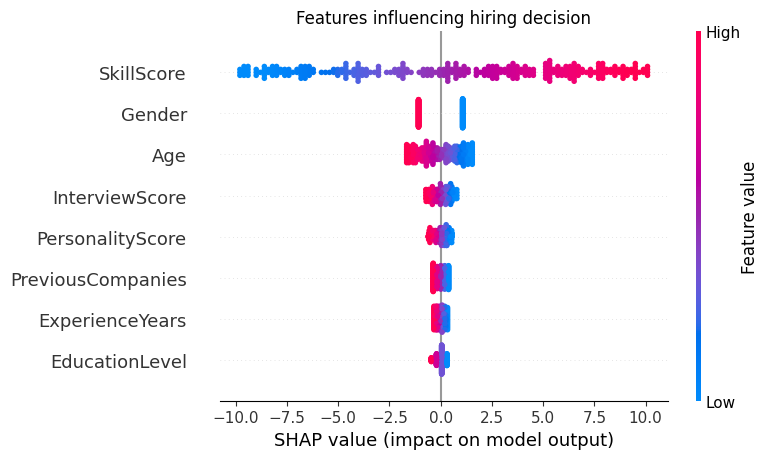

In [7]:
#create shap explainer
explainer = shap.LinearExplainer(model, X_train)

#calculate shap values
shap_values = explainer.shap_values(X_test)

#plot shap values
plt.title("Features influencing hiring decision")
shap.summary_plot(shap_values, X_test)

        accuracy  selection_rate  count
Gender                                 
0       0.954545        0.350649  154.0
1       0.945205        0.178082  146.0


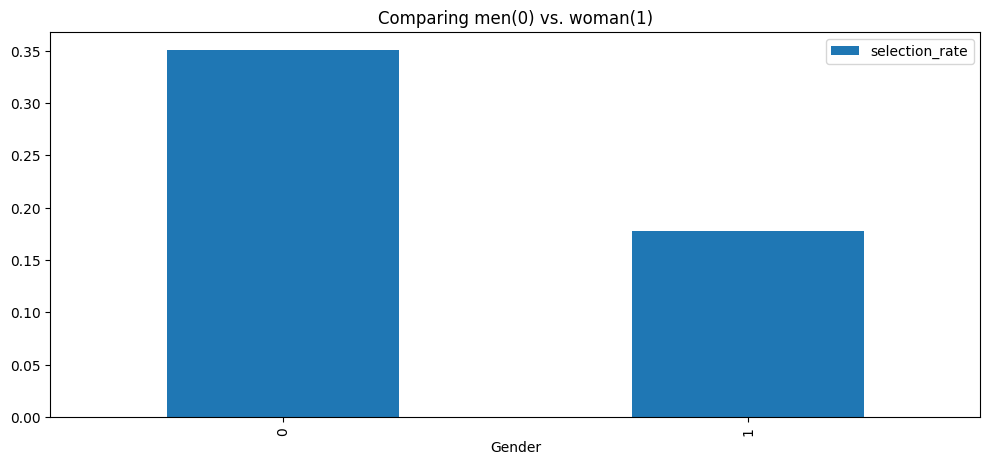

In [8]:
#define relevant metrics
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'count': count
}

#create metricFrame
mf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test["Gender"]
)

print(mf.by_group)
#visualise difference
mf.by_group[['selection_rate']].plot(
    kind='bar',
    figsize=(12, 5),
    title="Comparing men(0) vs. woman(1)"
)
plt.show()

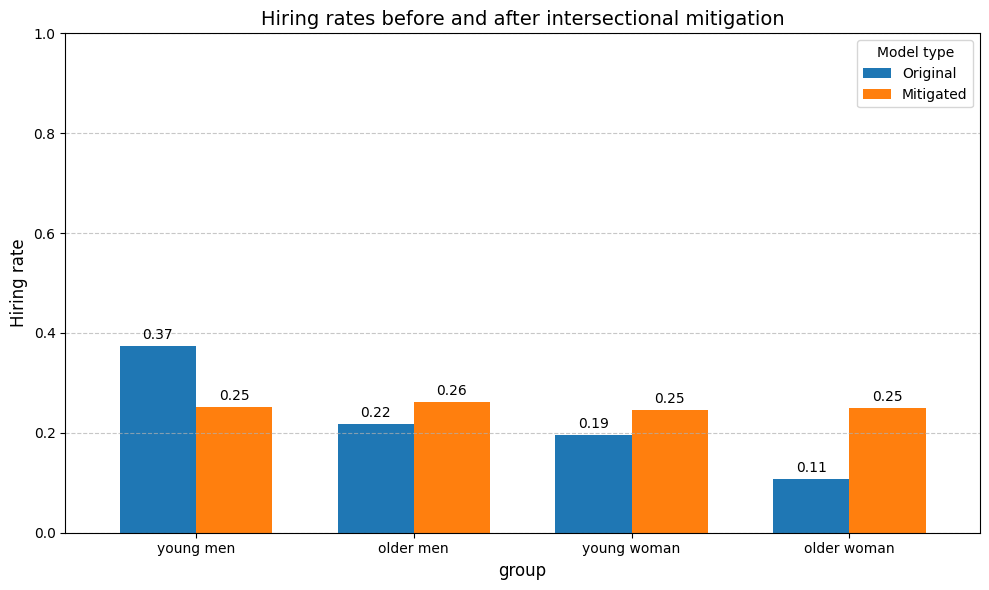

In [19]:


#create intersectional features
sens_train = X_train['Gender'].astype(str) + "_" + (X_train['Age'] > 45).astype(str)
sens_test = X_test['Gender'].astype(str) + "_" + (X_test['Age'] > 45).astype(str)

# --- 2. Mitigation (ThresholdOptimizer) ---
optimizer = ThresholdOptimizer(
    estimator=model,
    constraints="demographic_parity",
    predict_method='predict_proba',
    prefit=True
)

#train the optimizer
optimizer.fit(X_train, y_train, sensitive_features=sens_train)

#get prediction values
y_pred_fair = optimizer.predict(X_test, sensitive_features=sens_test)

#original models metricFrame
mf_original = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=model.predict(X_test),
    sensitive_features=sens_test
)

#mitigated models metricFrame
mf_mitigated = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sens_test
)

#get old and new values
results_df = pd.DataFrame({
    'Original': mf_original.by_group,
    'Mitigated': mf_mitigated.by_group
})

#for better readability
label_map = {
    '0_False': 'young men',
    '0_True':  'older men',
    '1_False': 'young woman',
    '1_True':  'older woman'
}
results_df.index = results_df.index.map(lambda x: label_map.get(x, x))

#create plot
ax = results_df.plot(kind='bar', figsize=(10, 6), width=0.7)
plt.title("Hiring rates before and after intersectional mitigation", fontsize=14)
plt.ylabel("Hiring rate", fontsize=12)
plt.xlabel("group", fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model type")
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()